In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm
%matplotlib inline
df_t = pd.read_csv('Проект_3_users_test.csv', sep=';')
df_c1 = pd.read_csv('Проект_3_users_control_1.csv', sep=';')
df_c2 = pd.read_csv('Проект_3_users_control_2.csv', sep=';')

trans_t = pd.read_csv('Проект_3_transactions_test.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
trans_c1 = pd.read_csv('Проект_3_transactions_control_1.csv', sep=';', parse_dates=['joined_at', 'paid_at']).dropna()
trans_c2 = pd.read_csv('Проект_3_transactions_control_2.csv', sep=';', parse_dates=['joined_at', 'paid_at'])

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.





Для начала сверим показатели в общих таблицах и таблицах с транзакциями, чтобы убедиться, что все платежи правильно внесены в сводную таблицу.

In [9]:
trans_c1.revenue.sum() == df_c1.total_revenue.sum()

False

In [10]:
trans_c1.revenue.sum()

2612311.0

In [12]:
df_c1.total_revenue.sum()

2581267

In [13]:
trans_c1_tot_rev = trans_c1.groupby('uid', as_index=False).agg({'revenue': 'sum'})

In [14]:
uid_c1 = set(trans_c1.uid.values)

In [12]:
for uid in uid_c1:
    if df_c1.query('uid == @uid').total_revenue.values[0] != trans_c1_tot_rev.query('uid == @uid').revenue.values[0]:
        print(f'''For uid {uid} revenue 
        in df_c1 is {df_c1.query('uid == @uid').total_revenue.values[0]} 
        in trans_c1 is {trans_c1_tot_rev.query('uid == @uid').revenue.values[0]}''')
    else:
        continue

For uid 960936960.0 revenue 
        in df_c1 is 26 
        in trans_c1 is 806.0
For uid 892355163.0 revenue 
        in df_c1 is 0 
        in trans_c1 is 30264.0


In [16]:
trans_c1.query('uid == 960936960.0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


In [9]:
df_c1.query('uid == 960936960.0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26


In [10]:
trans_c1.query('uid == 892355163.0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
303,892355163.0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type


In [11]:
df_c1.query('uid == 892355163.0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
3370,892355163,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,NaN,0


Для пользователя с uid 960936960 в общую таблицу внесен только первый платеж, а для пользователя с uid 892355163 его единственный платеж в общую таблицу не попал. Исправим это вручную

In [12]:
df_c1.loc[510, 'total_revenue'] = 806.0

In [13]:
df_c1.query('uid == 960936960.0 ')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
510,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,806.0


In [14]:
df_c1.loc[3370, 'total_revenue'] = 30264.0

In [15]:
df_c1.query('uid == 892355163.0')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
3370,892355163,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,NaN,30264.0


In [16]:
trans_c2.revenue.sum() == df_c2.total_revenue.sum()

True

In [17]:
trans_t.revenue.sum() == df_t.total_revenue.sum()

False

In [18]:
trans_t.revenue.sum()

2344901

In [19]:
df_t.total_revenue.sum()

2300818

In [20]:
trans_t_tot_rev = trans_t.groupby('uid', as_index=False).agg({'revenue': 'sum'})

In [21]:
uid_t = set(trans_t.uid.values)

In [22]:
for uid in uid_t:
    if df_t.query('uid == @uid').total_revenue.values[0] != trans_t_tot_rev.query('uid == @uid').revenue.values[0]:
        print(f'''For uid {uid} revenue 
        in df_t is {df_t.query('uid == @uid').total_revenue.values[0]} 
        in trans_t is {trans_t_tot_rev.query('uid == @uid').revenue.values[0]}''')
    else:
        continue 

For uid 892275462 revenue 
        in df_t is 14885 
        in trans_t is 58968


In [23]:
trans_t.query('uid == 892275462')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
64,892275462,France,2017-10-17 05:56:00,2017-02-11 18:24:00,44083,19,coins_popup,other_type
154,892275462,France,2017-10-17 05:56:00,2017-10-20 17:00:00,14885,68,super_popup,other_type


In [24]:
df_t.query('uid == 892275462')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
2070,892275462,31,310,NaN,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,14885


В общую таблицу попал только второй платеж, исправим.

In [25]:
df_t.loc[2070, 'total_revenue'] = 58968.0

In [26]:
df_t.query('uid == 892275462')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
2070,892275462,31,310,NaN,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,58968.0


Рассмотрим, насколько сильные изменения произошли в стоимости премиум-подписки, насколько существенна эта статья доходов для приложения, а также как много пользователей в целом тратят деньги в приложении

In [25]:
pr_n_t_c1 = trans_c1.query('product_type == "premium_no_trial"').revenue.mean()

In [26]:
pr_n_t_c2 = trans_c2.query('product_type == "premium_no_trial"').revenue.mean()

In [27]:
pr_n_t_t = trans_t.query('product_type == "premium_no_trial"').revenue.mean()

In [28]:
pr_n_t_t / ((pr_n_t_c1 + pr_n_t_c2) / 2)

1.490628414391113

In [31]:
trans_c1.groupby('product_type', as_index=False).agg({'revenue': 'sum'}).sort_values('revenue', ascending=False)

,product_type,revenue
0,coins,871910.0
2,premium_no_trial,779259.0
3,trial_premium,772720.0
1,other_type,188422.0


In [32]:
trans_c2.groupby('product_type', as_index=False).agg({'revenue': 'sum'}).sort_values('revenue', ascending=False)

,product_type,revenue
2,premium_no_trial,744809
3,trial_premium,643981
0,coins,402909
1,other_type,128739


In [33]:
trans_t.groupby('product_type', as_index=False).agg({'revenue': 'sum'}).sort_values('revenue', ascending=False)

,product_type,revenue
2,premium_no_trial,810706
3,trial_premium,800202
0,coins,566176
1,other_type,167817


In [34]:
df_c1.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,60.0000,4340.000000,4340.000000,4340.000000,4340.000000,436.0,192.0,4340.000000
mean,8.917578e+08,32.095392,312.048848,1745.9000,0.958065,26.793779,38.553226,44.467512,1.0,1.0,601.914977
std,1.125683e+06,10.257466,320.972130,12902.3577,0.200465,9.405103,15.226951,204.800272,0.0,0.0,8000.599238
min,8.910510e+08,16.000000,0.000000,1.0000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913626e+08,24.000000,0.000000,8.0000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917272e+08,30.000000,238.500000,11.5000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920898e+08,38.000000,518.000000,28.0000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,9.609370e+08,99.000000,1000.000000,99958.0000,1.000000,96.000000,102.000000,4953.000000,1.0,1.0,486330.000000


In [35]:
df_c2.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,61.000000,4264.000000,4264.000000,4264.000000,4264.000000,411.0,191.0,4264.000000
mean,8.917694e+08,32.046201,317.957317,18.147541,0.954268,26.954268,38.906895,45.064493,1.0,1.0,450.384146
std,2.520759e+06,10.170721,326.191737,35.439543,0.208927,9.546657,15.955574,318.188992,0.0,0.0,2859.242228
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913453e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917205e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920735e+08,38.000000,548.500000,20.000000,1.000000,32.000000,45.000000,20.000000,1.0,1.0,0.000000
max,1.053059e+09,99.000000,1000.000000,271.000000,1.000000,94.000000,99.000000,16157.000000,1.0,1.0,81796.000000


In [36]:
df_t.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
mean,8.917437e+08,31.889276,316.411328,229.836735,0.953110,26.701486,38.248839,50.391133,1.0,1.0,544.313138
std,4.547670e+05,10.245287,323.373725,1205.819471,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4456.060096
min,8.910511e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.0,1.0,129870.000000


Повышение средней стоимости премиум подписки в тестовой группе в сравнении со средним значением контрольной группы произошло на 49%, при этом доходы от продажи премиум-подписок составляют существенную часть от общего дохода, получаемого от группы пользователей, поэтому в результате эксперимента могут привести к значимому увеличению ключевых бизнесовых показателей. 
При этом количество платящих пользователей в каждой из групп невелико (75 процентиль равен 0).

Ключевые метрики, которые будут проанализированы в настоящем исследовании, следующие: ARPU, ARPPU, CR в разрезе premium_no_trial (для проверки того, не стали ли пользователи отказываться от премиум-аккаунтов в связи с повышением цены).

Проведен ААВ тест, для начала проанализируем результат в 2х контрольных группах (АА-тест), для того, чтобы убедиться, что система сплитования работает корректно. 

Начнем с анализа показателя total_revenue. Среднее значение total_revenue, по сути, отождествляется с такой метрикой, как ARPU.
Посмотрим на распределение значений этого признака в 2 контрольных группах, чтобы выяснить, какой статистический оценщик использовать для подсчета р-value.

In [30]:
ARPU_c1 = df_c1.total_revenue.mean()
ARPU_c2 = df_c2.total_revenue.mean()
ARPU_t = df_t.total_revenue.mean()
ARPU_diff_c1 = round((ARPU_t - ARPU_c1) / ARPU_c1 * 100, 2)
ARPU_diff_c2 = round((ARPU_t - ARPU_c2) / ARPU_c2 * 100, 2)

In [33]:
pd.DataFrame({'ARPU': [ARPU_c1, ARPU_c2, ARPU_t, ARPU_diff_c1, ARPU_diff_c2]},
             index=['c1', 'c2', 't', 'diff_c1', 'diff_c2'])

,ARPU
c1,594.761982
c2,450.384146
t,534.080316
diff_c1,-10.200000
diff_c2,18.580000


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


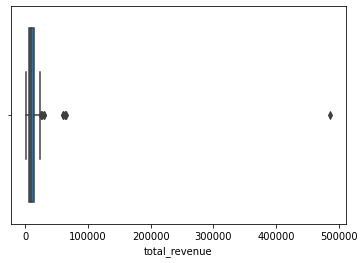

In [39]:
sns.boxplot(df_c1[df_c1.total_revenue > 0].total_revenue)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


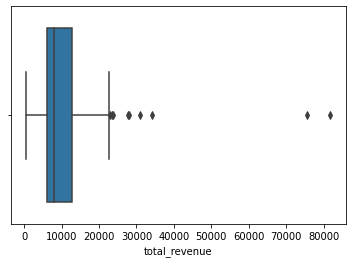

In [40]:
sns.boxplot(df_c2[df_c2.total_revenue > 0].total_revenue)

Как видно на графиках, в обеих выборках присутствуют выбросы, в особенности в первой выборке, где максимальное значение ARPPU составило почти 500.000, данный вопрос требует более детального изучения. Были ли еще такие пользователи в нашем приложении (возможно, да, но они не попали ни в одну из групп, или это единственный пользователь, в таком случае его нельзя "правильно" распределить по сплитам). Удаление выбросов по финансовым показателям в большинстве случаев не является хорошей практикой.

Как альтернативу, возможно, стоило бы попробовать отсечь топ n% пользователей на предэкспериментальном периоде (например, топ 1% юзеров по выручке за 2 месяца до эксперимента, когда никакого тритмента не было в тесте).
Но, применяя такую тактику, мы автоматически принимаем, что топ пользователей поведёт себя также, как и остальные пользователи, или лучше (что не всегда так, но это предположение можно провeрить на старых АВ-тестах).

Едва ли распределение total_revenue в контрольных группах претедует на нормальность, но подтвердим это на тестах (проведем тест Шапиро-Уилка).

In [41]:
stats.shapiro(df_c1.total_revenue)

ShapiroResult(statistic=0.03986465930938721, pvalue=0.0)

In [42]:
stats.shapiro(df_c2.total_revenue)

ShapiroResult(statistic=0.1445736289024353, pvalue=0.0)

Необходимо выбрать статистичеcкий оценщик, которым может быть t-тест, критерий Манна-Уитни или бутстрап.

Для t-теста необходимым условием является соблюдение требования о нормальности распределения, что в нашем случае не соблюдается, кроме того, присутствуют сильные выбросы.

Таким образом, можно использовать критерий Манна-Уитни или бутстрап (с np.mean).

Н0 для критерия Манна-Уитни:  равенство распределений в двух группах (случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки).

Н0 для бутстрапа: средние значения выборок равны (разность средних значений равна нулю).

In [ ]:
def aa_test(statistic, data1, data2, n_s=1000):
    """
    Функция aa_test возвращает количество ложноположительных случаев 
    (проверяет, что количество ложноположительных случаев не превышает альфа)
    
    Параметры:
    - использумый статистический оценщик
    - числовые значения первой выборки
    - числовые значения второй выборки"""
    simulations = 1000
    res = []
    if n_s > min([len(data1), len(data2)]):
        n_s = min([len(data1), len(data2)])

    for i in range(simulations):
        s1 = data1.sample(n_s, replace=False).values
        s2 = data2.sample(n_s, replace=False).values
        res.append(statistic(s1, s2)[1])  # сохраняем pvalue

    return sum(np.array(res) < 0.05) / simulations

In [ ]:
aa_test(mannwhitneyu, df_c1.total_revenue, df_c2.total_revenue)

In [46]:
def get_bootstrap_aa_mean(
    data_column_1,
    data_column_2, 
    boot_it=1000, 
    statistic=np.mean, 
    bootstrap_conf_level=0.95
):
    """
    Параметры:
    data_column_1 - числовые знаения первой выборки
    data_column_2 - числовые значения второй выборки
    boot_it - количество бутстрэп-подвыборок
    statistic - применяемая статистика
    bootstrap_conf_level - уровень значимости"""
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
      
    p_1 = stats.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
       
    return p_value

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


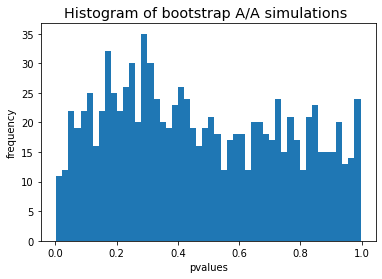

0.031

In [47]:
simulations = 1000
n_s = 100
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_c1.total_revenue.sample(n_s, replace=False).values
    s2 = df_c2.total_revenue.sample(n_s, replace=False).values
    res.append(get_bootstrap_aa_mean(pd.DataFrame(s1), pd.DataFrame(s2), boot_it=1000, bootstrap_conf_level=0.95)) 

plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Оба теста не выявили статистически значимых различий в значении показателя total_revenue для с1 и с2, полагаем, что система сплитования работает корректно.

Проанализируем, есть ли значимые различия в значении total_revenue между тестовой и обеими контрольными группами.

Н0 - размер общего дохода в контрольной и тестовой группах статистически не различается, любые различия случайны.
Н1 - различия размера общего дохода в группах статистически значимы.

Проведем также АА-тест с ARPPU.

In [47]:
ARPPU_c1 = df_c1[df_c1.total_revenue > 0].total_revenue.mean()
ARPPU_c2 = df_c2[df_c2.total_revenue > 0].total_revenue.mean()
ARPPU_t = df_t[df_t.total_revenue > 0].total_revenue.mean()
ARPPU_diff_c1 = round((ARPPU_t - ARPPU_c1) / ARPPU_c1 * 100, 2)
ARPPU_diff_c2 = round((ARPPU_t - ARPPU_c2) / ARPPU_c2 * 100, 2)

In [48]:
pd.DataFrame({'ARPPU': [ARPPU_c1, ARPPU_c2, ARPPU_t, ARPPU_diff_c1, ARPPU_diff_c2]},
             index=['c1', 'c2', 't', 'diff_c1', 'diff_c2'])

,ARPPU
c1,13535.290155
c2,10269.721925
t,16060.965753
diff_c1,18.660000
diff_c2,56.390000


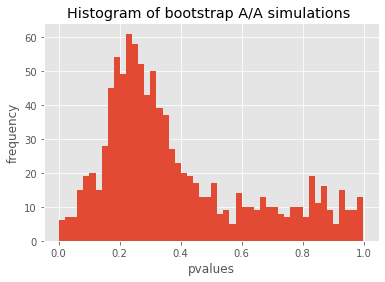

0.016

In [49]:
simulations = 1000
n_s = 100
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_c1.query('total_revenue > 0').total_revenue.sample(n_s, replace=False).values
    s2 = df_c2.query('total_revenue > 0').total_revenue.sample(n_s, replace=False).values
    res.append(get_bootstrap_aa_mean(pd.DataFrame(s1), pd.DataFrame(s2), boot_it=1000, bootstrap_conf_level=0.95)) 
    
plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of bootstrap A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

В АА-тесте с ARPPU количество ложноположительных случаев также не превышает уровень альфа.

Проверим, равномерно ли распределены по выборкам платящие пользователи, а также количество покупок premium no trial (используем критерий хи-квадрат).
Н0: взаимосвязи между нахождением в определенной группе и количеством покупателей премиума нет.

In [50]:
df_c1_paid = df_c1.query('total_revenue > 0').shape[0]
df_c2_paid = df_c2.query('total_revenue > 0').shape[0]

df_c1_users = df_c1.shape[0]
df_c2_users = df_c2.shape[0]

In [51]:
stat, p, dof, expected = stats.chi2_contingency([[df_c1_paid, df_c2_paid], [df_c1_users, df_c2_users]])
p

0.9360068766139246

In [48]:
stat, p, dof, expected = stats.chi2_contingency([[df_c1.shape[0], df_c2.shape[0]],
                                                 [trans_c1.query('product_type == "premium_no_trial"').shape[0],
                                                  trans_c2.query('product_type == "premium_no_trial"').shape[0]]])
p

0.8999875283496306

p-value > 0.05, т.е. мы не можем отвергнуть Н0, количество платящих пользователей, а также доля покупок premium_no_trial статистически не различаются для двух выборок.

По основным анализируемым показателям проблем в сплитовании выявлено не было, поэтому для дальнейшей статистической оценки объединим контрольные группы.

In [54]:
df_c_all = pd.concat([df_c1, df_c2], ignore_index=True)

Проверим гипотезу о том, что ARPU в тестовой группе статистически не отличается от ARPU в контрольной группе. Для оценки используем бутсрап с оценкой разницы средних значений. (Н0: среднее значение ARPU тестовой группы = среднее значение ARPU контрольной группы). 

In [44]:
def get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    """
    Параметры
    числовые значения первой выборки
    числовые значения второй выборки
    количество бутстрэп-подвыборок
    применяемая статистика
    уровень значимости
    """
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value, "ci": ci}

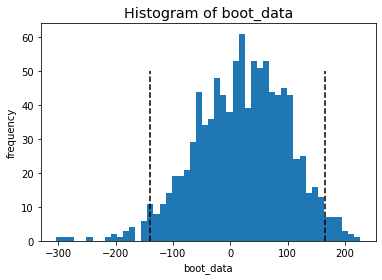

{'p_value': 0.7947125588905678,
 'ci':                 0
 0.025 -139.365772
 0.975  164.410452}

In [45]:
get_bootstrap(df_t.total_revenue, df_c_all.total_revenue, boot_it=1000)

p>0.05 => принимаем Н0 о том, что среднее значение ARPU тестовой группы не отличается статистически от такого значения контрольной группы, что может быть объяснено тем, что в нашем приложении достаточно небольшая (в объединенной контрольной группе 4,4%, в тестовой 3,4%) доля платящих пользователей.


In [46]:
df_c_all.query('total_revenue>0').shape[0] / df_c_all.shape[0]

0.04416550441655044

In [47]:
df_t.query('total_revenue>0').shape[0] / df_t.shape[0]

0.033890436397400185


Проведем анализ показателя ARPPU. Н0: разность средних значений ARPPU контрольной и тестовой группы равна 0.

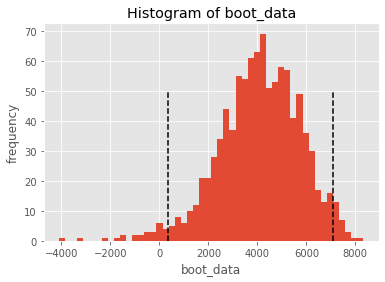

{'p_value': 0.014821536536517205,
 'ci':                  0
 0.025   359.733092
 0.975  7078.171579}

In [48]:
get_bootstrap(df_t.query('total_revenue > 0').total_revenue, df_c_all.query('total_revenue > 0').total_revenue)

p<0.05 => разность средних значений ARPPU в тестовой и контрольной группах статистически значимо отлична от 0.

In [49]:
ARPPU_t = df_t[df_t.total_revenue > 0].total_revenue.mean()
ARPPU_c = df_c_all[df_c_all.total_revenue > 0].total_revenue.mean()

round((ARPPU_t - ARPPU_c) / ARPPU_c, 4)

0.3465

Проверим, не повлекло ли за собой увеличение ARPPU снижение количества покупок, в частности покупок premium_no_trial

In [50]:
trans_c1['month'] = trans_c1.paid_at.dt.month
trans_c2['month'] = trans_c2.paid_at.dt.month
trans_t['month'] = trans_t.paid_at.dt.month
trans_c1['group'] = 'c1'
trans_c2['group'] = 'c2'
trans_t['group'] = 't'

In [51]:
trans_c_all = pd.concat([trans_c1, trans_c2])
trans_c_all['group_tc'] = 'c'
trans_c_all['prem'] = (trans_c_all.product_type == 'premium_no_trial')
trans_t['group_tc'] = 't'
trans_t['prem'] = (trans_t.product_type == 'premium_no_trial')
trans_all = pd.concat([trans_c_all, trans_t], ignore_index=True)

In [52]:
df_c1.query('total_revenue > 0').shape[0] / df_c1.shape[0]

0.044470046082949306

In [53]:
df_c2.query('total_revenue > 0').shape[0] / df_c2.shape[0]

0.04385553470919325

In [54]:
df_t.query('total_revenue > 0').shape[0] / df_t.shape[0]

0.033890436397400185

In [55]:
trans_c1.groupby(['product_type'], as_index=False).agg({'paid_at': 'count'})

,product_type,paid_at
0,coins,149
1,other_type,55
2,premium_no_trial,106
3,trial_premium,67


In [56]:
trans_c2.groupby(['product_type'], as_index=False).agg({'paid_at': 'count'})

,product_type,paid_at
0,coins,124
1,other_type,44
2,premium_no_trial,107
3,trial_premium,53


In [57]:
trans_t.groupby(['product_type'], as_index=False).agg({'paid_at': 'count'})

,product_type,paid_at
0,coins,106
1,other_type,29
2,premium_no_trial,76
3,trial_premium,62


Н0: взаимосвязи между нахождением в тестовой и контрольной группе и покупкой premium_no_trial нет

In [58]:
stat, p, dof, expected = stats.chi2_contingency([[df_t.shape[0], df_c_all.shape[0]],
                                                 [df_t.query('total_revenue > 0').shape[0],
                                                  df_c_all.query('total_revenue > 0').shape[0]]])
p

0.008516815450208316

In [59]:
stat, p, dof, expected = stats.chi2_contingency([[trans_t.shape[0], trans_c_all.shape[0]],
                                                 [trans_t.query('product_type == "premium_no_trial"').shape[0],
                                                  trans_c_all.query('product_type == "premium_no_trial"').shape[0]]])
p

0.6415610539659551

Наблюдаем значимое уменьшение как числа платящих пользователей в целом, так и покупателей премиум подписки. 

При этом распределение покупок премиумов без пробного периода среди всех покупок в группах остается равномерным. Возможно, пользователи без премиум аккаунта в меньшей степени нуждаются в других типах продуктов вроде монет (хотя для выдвижения и проверки такой гипотезы необходимо иметь больше данных о продукте). 

Интересно, что некоторые пользователи (около 20% от всех владельцев премиумов) имеют премиум подписку в настоящее время, при этом прибыль от них равна 0. Возможно, это стоило бы исследовать отдельно (Есть ли возможность приобретения премиума "для друга"? Или, например, за монеты, перечисленные другими пользователями?), чтобы выяснить, нет ли риска того, что при увеличении стоимости подписки станет больше желающих получить премиум доступ альтернативными путями.

In [123]:
df_c_all.query('total_revenue == 0 & is_premium == 1').shape[0] / df_c_all.query('is_premium == 1').shape[0]

0.2010443864229765

In [52]:
df_t.query('total_revenue == 0 & is_premium == 1').shape[0] / df_t.query('is_premium == 1').shape[0]

0.21656050955414013



Рассмотрим, как менялись обсуждаемые показатели в разрезе отдельных стран. Вопрос о том, какой набор стран для анализа является наиболее правильным, является дискуссионным. В данном случае будут рассмотрены те страны, в которых у нас есть платящие пользователи в объединенной контрольной группе, т.е. ARPU>0.

In [55]:
t_countries = df_t.groupby('country', as_index=False).agg({'total_revenue': 'mean'})
c_all_countr = df_c_all.groupby('country', as_index=False).agg({'total_revenue': 'mean'})

In [56]:
df_countries_ct = pd.merge(c_all_countr, t_countries, how='inner', on='country')
countries_for_research = df_countries_ct\
    .query('total_revenue_x>0 & total_revenue_y>0')\
    .reset_index()\
    .rename(columns={'total_revenue_x': 'control_ARPU', 'total_revenue_y': 'test_ARPU'})

In [62]:
countries_for_research['dif_ARPU_percent'] = ((countries_for_research.test_ARPU - (
    countries_for_research.control_ARPU)) / (countries_for_research.control_ARPU)) * 100

In [63]:
list_of_countries = list(countries_for_research.country.values)

In [64]:
ARPPU_countries_t = df_t.query('total_revenue>0')\
                        .groupby('country', as_index=False)\
                        .agg({'total_revenue': 'mean'})\
                        .rename(columns={'total_revenue': 'test_ARPPU'})

In [65]:
ARPPU_countries_c = df_c_all.query('total_revenue>0')\
                            .groupby('country', as_index=False)\
                            .agg({'total_revenue': 'mean'})\
                            .rename(columns={'total_revenue': 'control_ARPPU'})

In [66]:
countries_d = pd.merge(countries_for_research, ARPPU_countries_c, how='inner', on='country')
countries_data = pd.merge(countries_d, ARPPU_countries_t, how='inner', on='country')
countries_data['dif_ARPPU_percent'] = ((countries_data.test_ARPPU - countries_data.control_ARPPU) / (
    countries_data.control_ARPPU)) * 100

In [67]:
countries_data

,index,country,control_ARPU,test_ARPU,dif_ARPU_percent,control_ARPPU,test_ARPPU,dif_ARPPU_percent
0,1,Argentina,338.049618,474.795455,40.451410,12077.590909,26859.857143,122.394162
1,2,Australia,405.445545,203.177419,-49.887865,8190.000000,12597.000000,53.809524
2,3,Belgium,787.090909,681.369565,-13.431910,11131.714286,15671.500000,40.782449
3,4,Canada,457.425373,463.255474,1.274547,9430.000000,10577.666667,12.170378
4,5,Chile,359.825480,257.132353,-28.539704,9818.095238,17485.000000,78.089533
5,10,France,446.949062,829.247911,85.535217,8132.292683,22900.000000,181.593407
6,12,Germany,244.633333,459.789474,87.950459,9540.700000,13728.000000,43.888813
7,15,Israel,1001.695187,894.424528,-10.708912,9365.850000,18961.800000,102.456798
8,16,Italy,1192.847861,351.160991,-70.561125,22808.696970,12602.777778,-44.745735
9,27,Spain,449.138037,948.265781,111.130143,13944.666667,19028.533333,36.457427


In [68]:
def bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    """
    Параметры
    числовые значения первой выборки
    числовые значения второй выборки
    количество бутстрэп-подвыборок
    применяемая статистика
    уровень значимости
    """
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True 
        ).values

        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2)) 

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    return {"p_value": p_value, "ci": ci}

In [69]:
countries_up = []
countries_down = []
countries_and_p = []
for country in list_of_countries:
    print(country)
    p = bootstrap(df_t.query('country == @country & total_revenue>0').total_revenue,
                  df_c_all.query('country == @country & total_revenue>0').total_revenue,
                  bootstrap_conf_level=0.95)
    print(p)
    countries_and_p.append([country, p['p_value']])
    
    if p['p_value'] < 0.05 and countries_data.query('country == @country')['dif_ARPU_percent'].values[0] > 0:
        countries_up.append(country)
    elif p['p_value'] < 0.05 and countries_data.query('country == @country')['dif_ARPU_percent'].values[0] < 0:
        countries_down.append(country)
        
print(f'Страны, в которых ARPPU предположительно значимо увеличился, а также увеличился ARPU: {countries_up}')
print(f'Страны, в которых ARPPU предположительно значимо уменьшился, в то время как ARPU уменьшился: {countries_down}')    

Argentina
{'p_value': 0.011332049202249164}
Australia
{'p_value': 0.046657301679974346}
Belgium
{'p_value': 0.004806427878522896}
Canada
{'p_value': 0.6619324509277659}
Chile
{'p_value': 0.0013830542389903229}
France
{'p_value': 1.6486226789651126e-08}
Germany
{'p_value': 0.32629638928031}
Israel
{'p_value': 6.499986906426909e-10}
Italy
{'p_value': 0.4914432013172384}
Spain
{'p_value': 0.46806868933085977}
Switzerland
{'p_value': 0.4420585869948527}
Turkey
{'p_value': 0.24202294207670694}
United Arab Emirates
{'p_value': 0.5507034596610554}
United Kingdom (Great Britain)
{'p_value': 0.18592357082017275}
United States of America
{'p_value': 0.03526809763513986}
Страны, в которых ARPPU предположительно значимо увеличился, а также увеличился ARPU: ['Argentina', 'France', 'United States of America']
Страны, в которых ARPPU предположительно значимо уменьшился, в то время как ARPU уменьшился: ['Australia', 'Belgium', 'Chile', 'Israel']


Страны, которые будем в дальнейшем рассматривать как потенциально успешные, - это Аргентина, Франция, США. Проверим, не повлекло ли значимое увеличение ARPPU уменьшение количества платящих пользователей в этих странах. 

Для этих целей используем стратифицированную таблицу. Выдвигаемые гипотезы:
Распределение платящих пользователей не зависит от нахождения в контрольной или тестовой группе.
Это распределение одинаково во всех странах.

In [70]:
df_t['group'] = 't'
df_c_all['group'] = 'c'
df_all = pd.concat([df_t, df_c_all])
df_all['paid'] = df_all.total_revenue > 0

In [71]:
df_all_countries_up = df_all.query('country in @countries_up')

In [72]:
from statsmodels.stats.contingency_tables import StratifiedTable

StratifiedTable.from_data('group', 'paid', 'country', df_all_countries_up).summary()

,Estimate,LCB,UCB
Pooled odds,0.830,0.659,1.047
Pooled log odds,-0.186,-0.418,0.046
Pooled risk ratio,0.993,,
,,,
,Statistic,P-value,
Test of OR=1,2.474,0.116,
Test constant OR,1.310,0.519,
,,,
Number of tables,3,,
Min n,1465,,


Распределение одинаково в обеих группах (р = 0.116), и это распределение одинаково во всех странах (р = 0.519). Значит, увеличение ARPPU не привело к уменьшению количества платящих пользователей в рассматриваемых странах.

Теперь посмотрим на страны, значимое увеличение ARPPU в которых сопровождается падением ARPU (Австралия, Бельгия, Чили, Израиль). Воспользуемся тем же методом, что и выше.

In [73]:
df_all_countries_down = df_all.query('country in @countries_down')

In [74]:
from statsmodels.stats.contingency_tables import StratifiedTable

StratifiedTable.from_data('group', 'paid', 'country', df_all_countries_down).summary()

,Estimate,LCB,UCB
Pooled odds,0.510,0.298,0.872
Pooled log odds,-0.674,-1.211,-0.137
Pooled risk ratio,0.973,,
,,,
,Statistic,P-value,
Test of OR=1,6.254,0.012,
Test constant OR,0.380,0.944,
,,,
Number of tables,4,,
Min n,174,,


В этих странах наблюдается дисбаланс распределения количества платящих пользователей в тестовой и контрольной группах, что характерно для всех стран.

Применим поправку на множественное сравнение для того, чтобы снизить вероятность ложноположительных выводов.
За время исследования были протестированы следующие гипотезы:

1. ARPPU тестовой и контрольной групп не различается в Аргентине.
2. ARPPU тестовой и контрольной групп не различается в Австралии.
3. ARPPU тестовой и контрольной групп не различается в Бельгии.
4. ARPPU тестовой и контрольной групп не различается в Канаде.
5. ARPPU тестовой и контрольной групп не различается в Чили.
6. ARPPU тестовой и контрольной групп не различается во Франции.
7. ARPPU тестовой и контрольной групп не различается в Германии.
8. ARPPU тестовой и контрольной групп не различается в Израиле.
9. ARPPU тестовой и контрольной групп не различается в Италии.
10. ARPPU тестовой и контрольной групп не различается в Испании.
11. ARPPU тестовой и контрольной групп не различается в Швейцарии.
12. ARPPU тестовой и контрольной групп не различается в Турции.
13. ARPPU тестовой и контрольной групп не различается в ОАЭ.
14. ARPPU тестовой и контрольной групп не различается в Великобритании.
15. ARPPU тестовой и контрольной групп не различается в США.

Поправку Бонферрони хорошо работает, если число сравнений невелико. Если оно превышает 8, то метод становится слишком строгим (Гланц С., Медико-биологическая статистика).

Применим метод Холма-Бонферрони.

In [119]:
df_for_hb = pd.DataFrame(countries_and_p).rename(columns={0: 'name', 1: 'p'})
df_for_hb = df_for_hb.sort_values('p').reset_index()
all_p = list(df_for_hb['p'].values)

In [120]:
p_hb = []
num = 0
for p in all_p:
    num += 1
    p_cor = p * (len(all_p) - num + 1)
    p_hb.append([p, p_cor])    
df_cor = pd.DataFrame(p_hb)
df_cor.rename(columns={0: 'p', 1: 'p_cor'}, inplace=True)

In [121]:
p_hb_df = pd.merge(df_for_hb, df_cor, how='inner', on='p')
p_hb_df['accept'] = p_hb_df.p_cor < 0.05
p_hb_df

,index,name,p,p_cor,accept
0,7,Israel,6.499987e-10,9.749980e-09,True
1,5,France,1.648623e-08,2.308072e-07,True
2,4,Chile,1.383054e-03,1.797971e-02,True
3,2,Belgium,4.806428e-03,5.767713e-02,False
4,0,Argentina,1.133205e-02,1.246525e-01,False
5,14,United States of America,3.526810e-02,3.526810e-01,False
6,1,Australia,4.665730e-02,4.199157e-01,False
7,13,United Kingdom (Great Britain),1.859236e-01,1.487389e+00,False
8,11,Turkey,2.420229e-01,1.694161e+00,False
9,6,Germany,3.262964e-01,1.957778e+00,False


Выводы
1. Было проведено ААВ-тестирование, при сравнении показателей ARPU, ARPPU и распределения платящих пользователей и покупателей premium_no_trial по контрольным группам статистически значимых различий выявлено не было, вследствие чего контрольные группы были объединены.

2. При сравнении тестовой группы с объединенной контрольной группой было установлено, что результатом эксперимента стало статистически значимое увеличение ARPPU (34,65%), которое, однако, сопровождается значимым уменьшением количества платящих пользователей, при этом распределение покупок premium_no_trial в общем количестве чеков остается равномерным в обеих группах. Возможно, это говорит о том, что отсутствие премиум аккаунта демотивирует пользователей покупать другие типы продуктов, хотя для более точного ответа на этот вопрос необходимо большее количество информации о рассматриваемом приложении, например, о том, какие именно возможности открывает наличие премиум аккаунта? Каким образом можно получить премиум аккаунт без финансовых вложений (таких пользователей около 20% от всех владельцев премимум-аккаунтов в обеих группах). 
Увеличение ARPPU, сопровождаемое падением конверсии, не может быть основанием для использования предлагаемых изменений на всех пользователях на постоянной основе.

3. Были проанализированы результаты проводимого эксперимента в разрезе отдельных стран. С учетом применяемой поправки на множественное сравнение принимаем гипотезы о том, что ARPPU значимо изменился в Израиле, Франции и Чили. При этом изменение ARPPU в Израиле и Чили сопровождается неравномерным распределением платящих пользователей между контрольной и тестовой группами, то есть приводит к уменьшению количества платящих пользователей, что негативно отражается на ARPU. В то время при увеличении ARPPU во Франции сохраняется равномерность распределения платящих пользователей между контрольной и тестовой группами, что не приводит к падению ARPU. Таким образом, можно сделать предположение о том, что предлагаемое изменение стоимости премиум подписки без пробного периода было успешным во Франции, но привело к снижению конверсии в Израиле и Чили. 